# Note
Run the shell command below and restart Jupyter to get the same theme I use

`jt -t chesterish -fs 135 -altp -tfs 11 -nfs 135 -cellw 88% -T`

# Summary Credit Risk Modelling

After some exploratory analysis, I opted for a Random Forest classifier to try and predict whether an applicant can be accuratly classified as `BAD` for the credit risk. Here's how I went about it:
  1. Try to determine a baseline by evaluating a model using all features. It appeared that the model was badly overfitting the training data.
  2. Using the feature importance I got with the 1st model, I created & evaluated multiple models by appending features one at a time from the most important to the least. This quickly showed that the model started over-fitting from the beginning. This indicates that some features lead the model to overfitting.
  3. To identify these features, I created all possible 2-combiantions of the features. This quickly showed that `duration`, `age` & `credit_amount` are the main culprits. 
  4. After removing these 2 features, I went ahead and created multiple N-combinations of the features (where N is in 3, 4, 15) to see how the model behaves with increasing number of features. It turns out that at high number of features it overfits the training data. 
  5. The best model was achieved with the features `checking_status, other_parties, property_magnitude, foreign_worker`. This model has the following perf. metrics
    - Accuracy (1 is best, 0 is worst)
        - Train set: 0.7.
        - Test set: 0.7.
    - MCC score (1 is best, 0 is as good as random, -1 is inverse pred)
        - Train set: 0.41.
        - Test set: 0.38
  6. The distribution of the credit risk is skewed in some direction for the "culprits" identified above (e.g. a lot of BAD risk for high amounts). This could explain the tendency of the model to overfit when trained with these features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef, accuracy_score
from sklearn.preprocessing import StandardScaler
from pandas.api.types import is_string_dtype
from typing import Union
from itertools import combinations
from tqdm import tqdm

# Settings

In [2]:
dataset_path = "/Users/aalloul/Downloads/equal_experts_assignment/credit-g.csv"

In [3]:
# Display all columns (instead of having ellipses)
pd.options.display.max_columns = None

In [4]:
# set the theme of the plots and a default size
jtplot.style(theme='onedork', figsize=(12, 8))

# Read data

In [5]:
df = pd.read_csv(dataset_path)
# rename some classes to remove useless space
# the word `class` is reserved in pandas, so I rename the class column to output_class
df.rename(columns={" other_payment_plans": "other_payment_plans",
                   ' foreign_worker': 'foreign_worker',
                  "class": "output_class"},
          inplace=True)
display(df.head())

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,output_class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,4,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,2,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,3,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,4,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,4,no known property,53,none,for free,2,skilled,2,none,yes,bad


# Data exploration

## Summary
  - The dataset has 1000 rows and 21 columns
  - There are 7 numerical columns of which 4 are integers (i.e. not continuous)
  - There are 13 categorical columns and most of them display some form of imbalance
  - The output columns (named `class`) also displays some imabalance (30% `bad`, 70% `good`)
  - There doesn't seem to be any missing or weird (_i.e._ outlier, None / NULL / etc)  values
  
Data features driving the risk:
  - A loan above 11k seems to have at least 2 times more risk of defaulting
  - A credit_history value of `no credits/all paid` or `all paid` also has around 2 times more risk of defaulting
  - A checking_status: `<0` (assuming this means negative balance) has 1.5 more chances of defaulting
  - A duration above 45 months has at least 1.5 times more chances of defaulting

Some more observations about the risk
  - The number of dependents doesn't have an influence on the credit risk
  - Risk decreases with age, esp. after 30yo. Though the age groups (55-59) and (65-69) seem to have a slightly higher risk

## Numeric columns

In [6]:
df.describe(include=None)

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


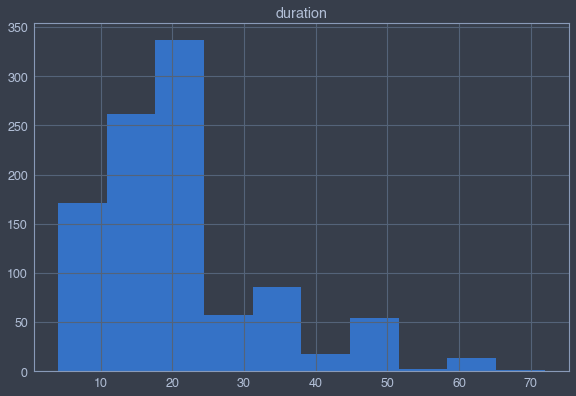

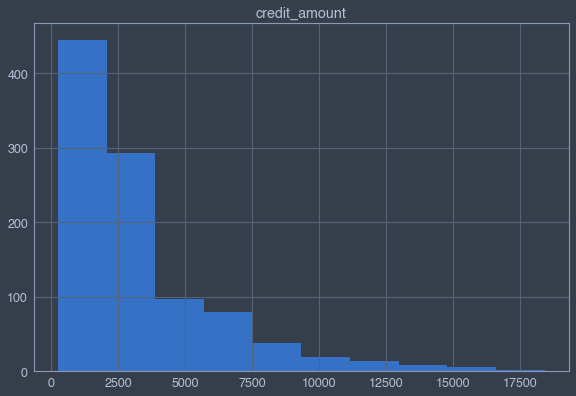

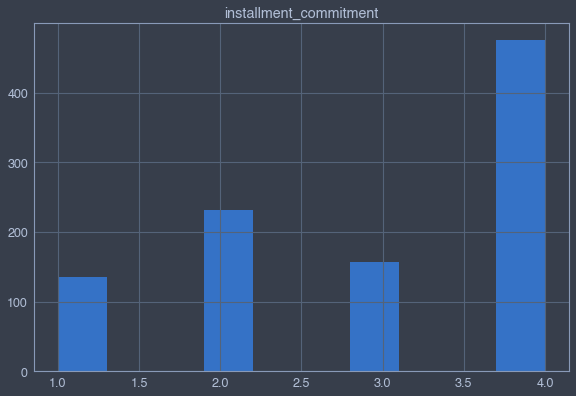

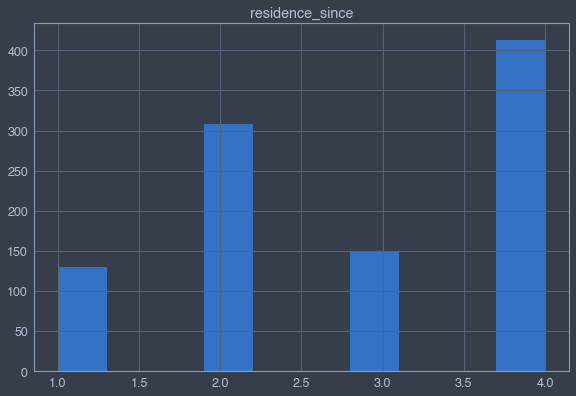

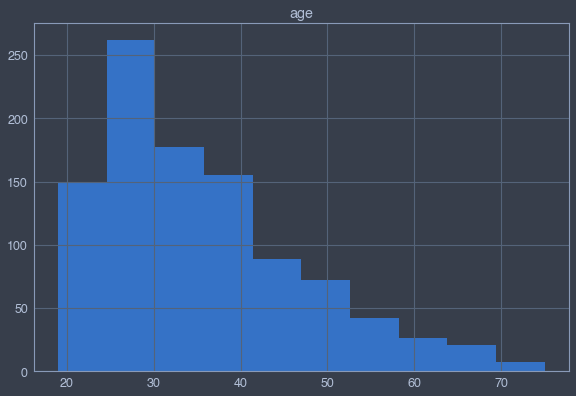

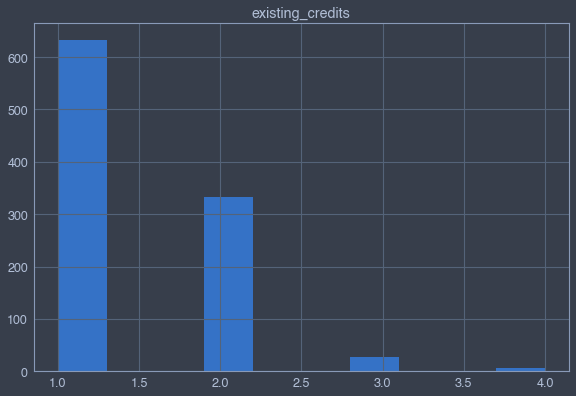

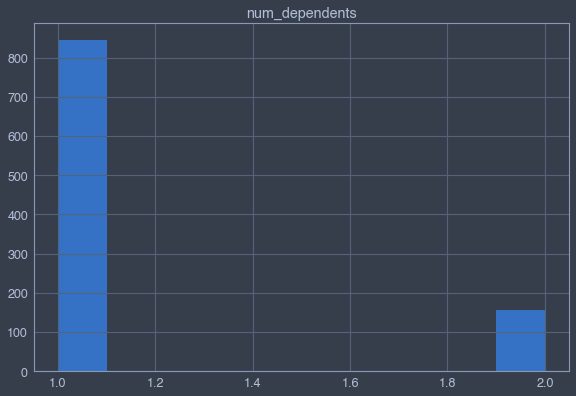

In [7]:
numerical_columns = ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
for column in numerical_columns:
    df[column].hist()
    plt.title(column)
    plt.show()

#### Takeaway
  - The feature `existing_credits` shows a small imbalance favoring applicants with 1 or 2 credits. Some others have 3 or 4.
  - The feature `num_dependents` displays an imabalance towards the number 1 (`~84%`) vs 2 (`~16%`)
  - The features `existing_credits, num_dependents, installment_commitment, residence_since` should probably be used as categorical as they're integers with limited values

## Categorical columns

In [8]:
df.describe(include=np.object)

,checking_status,credit_history,purpose,savings_status,employment,personal_status,other_parties,property_magnitude,other_payment_plans,housing,job,own_telephone,foreign_worker,output_class
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,4,5,10,5,5,4,3,4,3,3,4,2,2,2
top,no checking,existing paid,radio/tv,<100,1<=X<4,male single,none,car,none,own,skilled,none,yes,good
freq,394,530,280,603,339,548,907,332,814,713,630,596,963,700


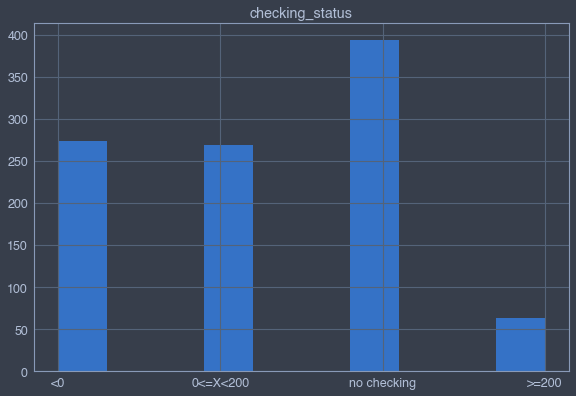

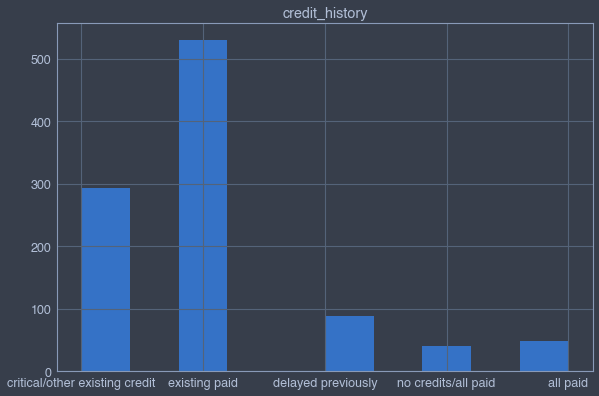

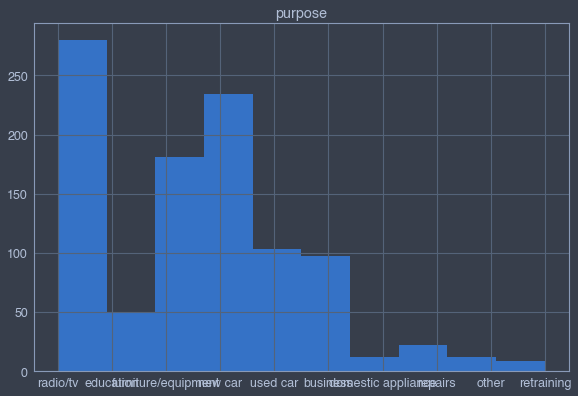

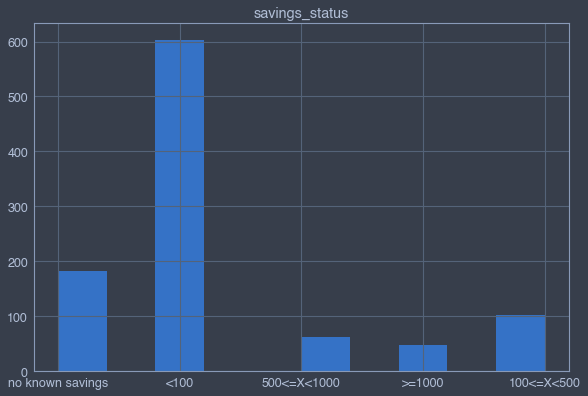

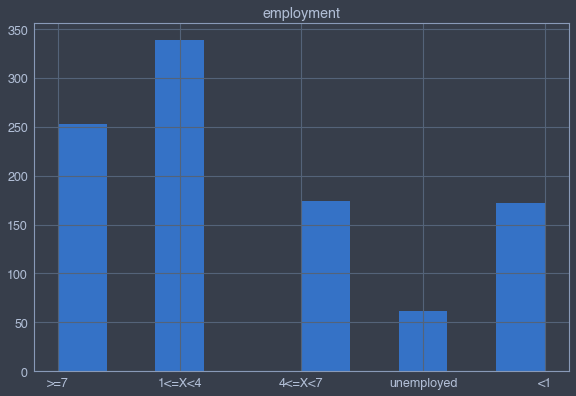

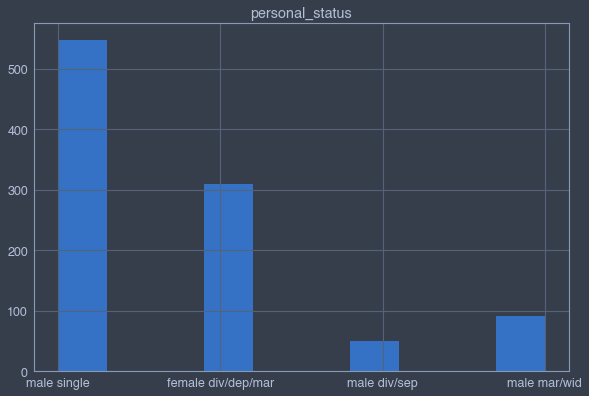

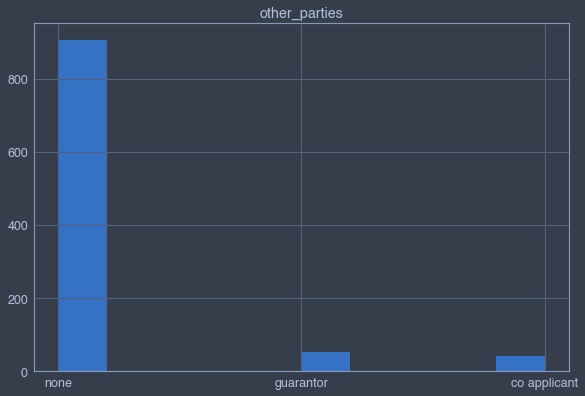

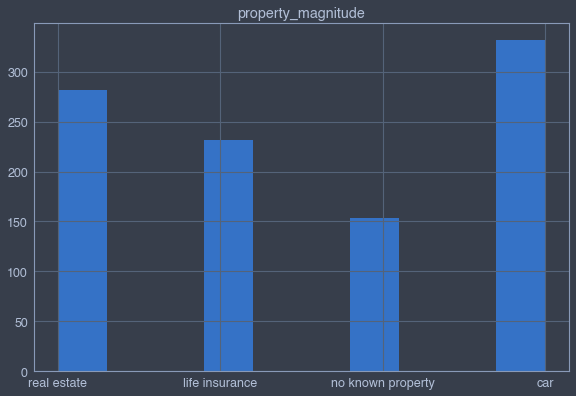

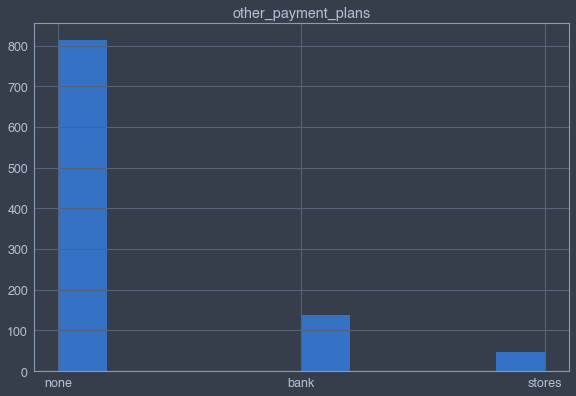

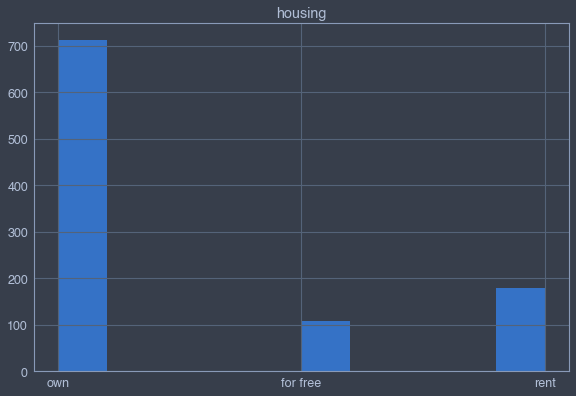

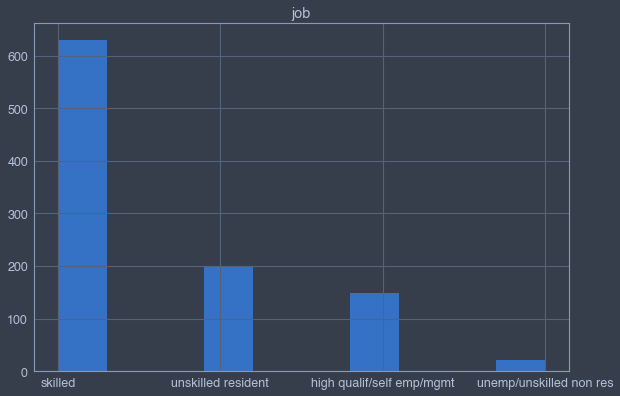

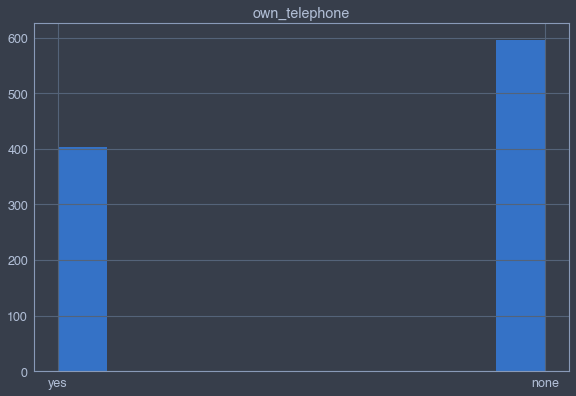

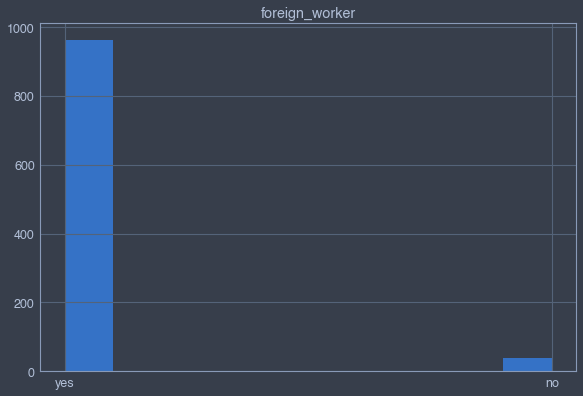

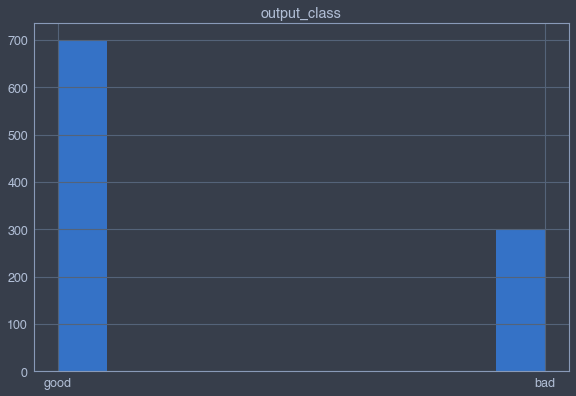

In [9]:
cat_columns = ["checking_status", "credit_history", "purpose", "savings_status", "employment", "personal_status",
               "other_parties", "property_magnitude", "other_payment_plans", "housing", "job", "own_telephone",
               "foreign_worker", "output_class"]
for column in cat_columns:
    df[column].hist()
    plt.title(column)
    plt.show()

#### Takeaway
  - The features `credit_history`, `purpose`, `savings_status`, `other_parties`, `other_payment_plans`, `housing`, `job`, `foreign_worker` are quite imabalanced
  - There's 30% loan applicants that are classified as "BAD". This dataset is thus imbalanced but it's not extreme. 
  - To avoid over-fitting, I'll use stratified sampling to make sure I have the right amount of each class in both the training and testing sets.

## Correlation between features and output column

In [10]:
def pivot_with_output_class(input_df: pd.DataFrame, other_column: str, 
                            class_column: str = "output_class", 
                            add_class_name: bool = True) -> pd.DataFrame:
    """
    Returns the input_df as a pivoted table where:
      - the index is the `other_column`
      - the columns are the `class_column`
      - the values is the % of observations for each combination <class_column, other_column>
    This is useful to plot these 2 columns and observe their "correlation"
    :param input_df: input data frame
    :param other_column: name of the column to use for the pivot. 
    This column will be used for the index of the resulting pivot
    :param class_column: name of the column to use for the pivot
    :param add_class_name: Boolean to indicate whether to add the string `other_column` to the values
    in the index
    :return: a pivoted DataFrame.
    """
    obs = df\
        .groupby([class_column, other_column])\
        .size()\
        .rename("observations")\
        .reset_index()
    tot_obs = df\
        .groupby(other_column)\
        .size()\
        .rename("total_observations")\
        .reset_index()
    tmp = obs.merge(tot_obs)
    tmp['percent_observations'] = (100*tmp.observations / tmp.total_observations).round(1)
    output = tmp \
        .pivot(index=other_column, columns=class_column, values="percent_observations")    
    # Renamem the index by prepending the name of the class
    if add_class_name:
        output.index = other_column + " - " + output.index 
    return output

### Categorical columns

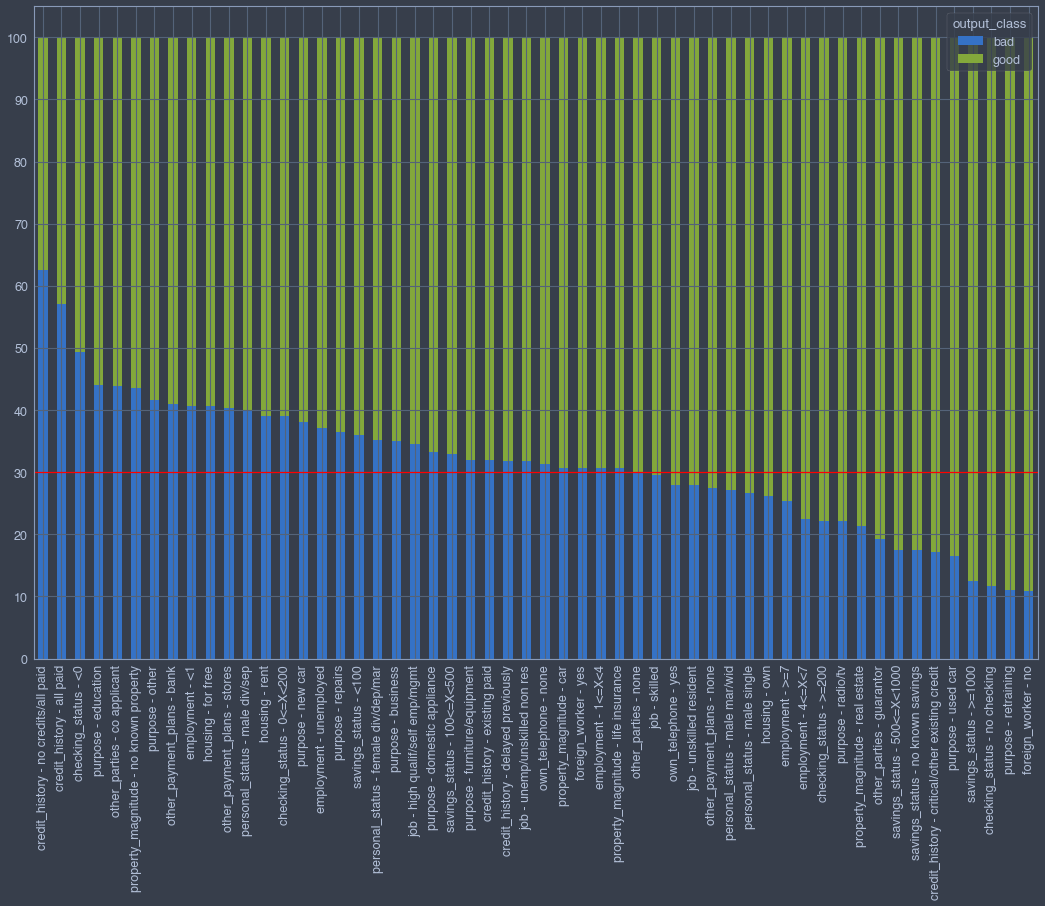

In [11]:
df_to_plot = pd.concat([pivot_with_output_class(df, cat_column) for cat_column in cat_columns if cat_column != "output_class"])
df_to_plot \
    .sort_values("bad", ascending=False) \
    .plot(kind="bar", stacked=True, figsize=(18, 12))
# Plot a line at 30% so that we can identify the class values where the `bad` output_class is over-represented wrt the dataset overall
plt.axhline(y=30, color="red")
plt.yticks(range(0, 101, 10))
plt.show()

#### Takeaways
  - Top 3 class values for an applicant to be classified as `bad`
      - credit_history: `no credits/all paid`
      - credit_history: `all paid`
      - checking_status: `<0`
  - Top 3 class values for an applicant to be classified as `good`
      - foreign_worker: `no`
      - purpose: `retraining`
      - checking_status: `no checking`

### Numerical columns

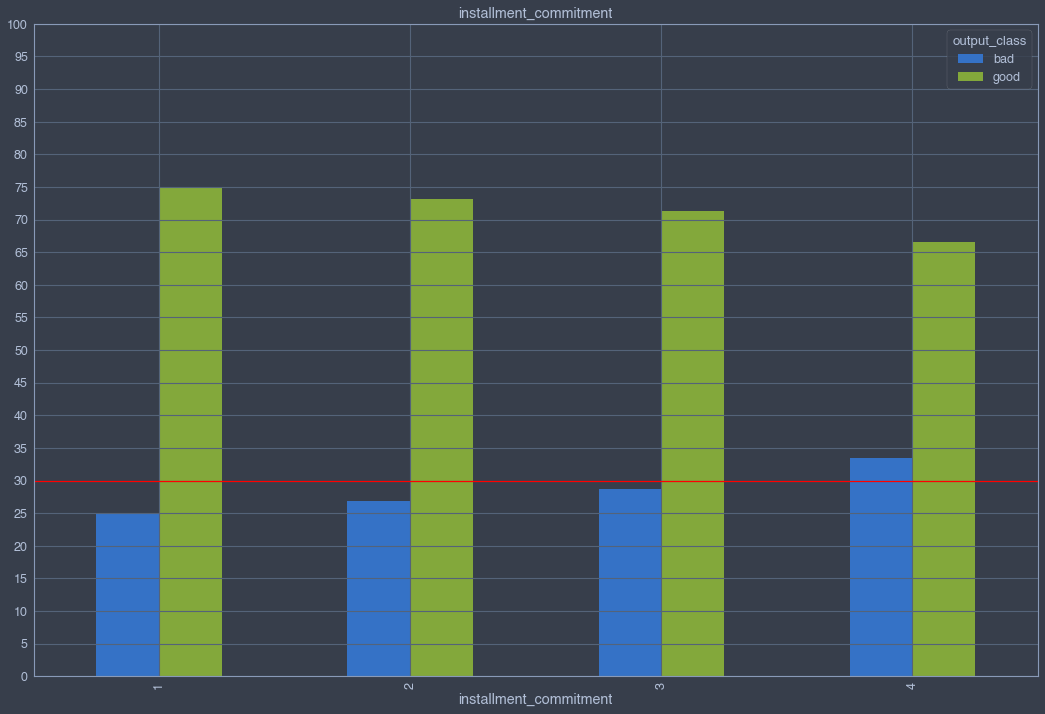

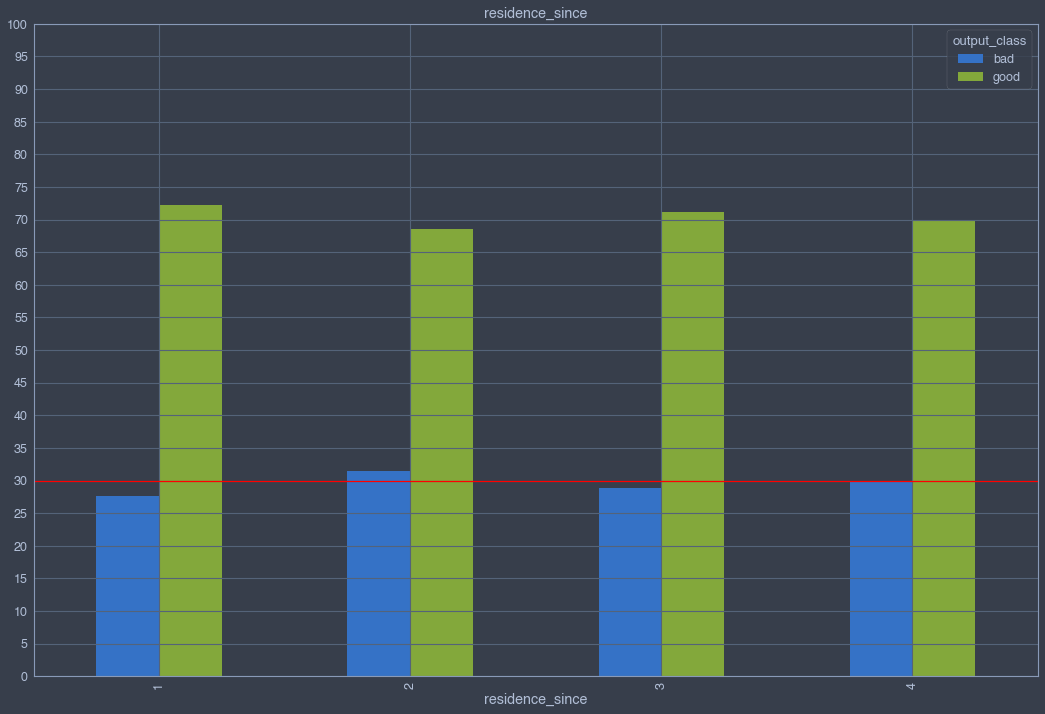

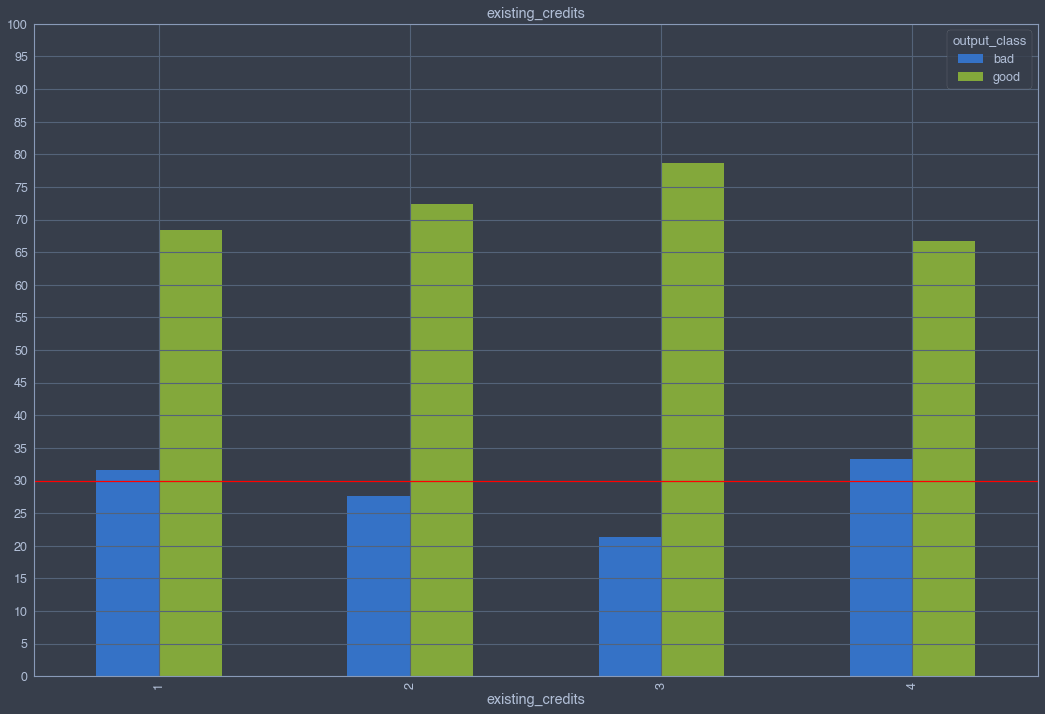

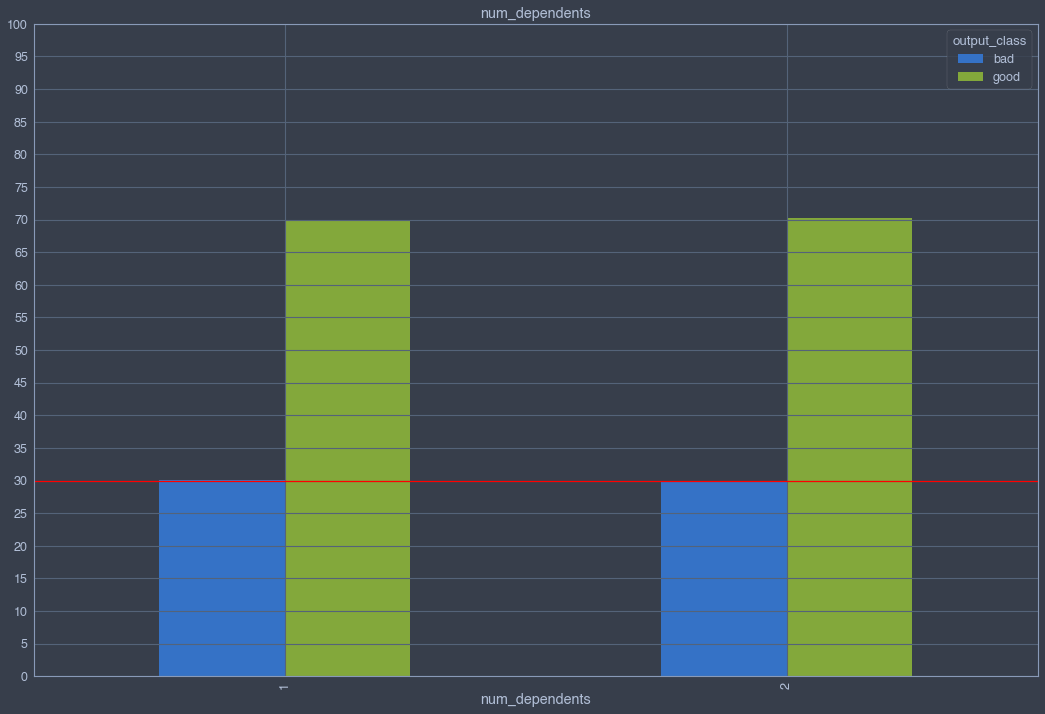

In [12]:
for num_col in numerical_columns:
    # There's too many values for credit_amount & age, better treat them separately
    if num_col in ["credit_amount", "age", "duration"]:
        continue
    pivot_with_output_class(df, num_col, add_class_name=False)\
        .plot(kind="bar", figsize=(18, 12), title=num_col)
    plt.yticks(range(0, 101, 5))
    plt.axhline(y=30, color="red")
    plt.show()

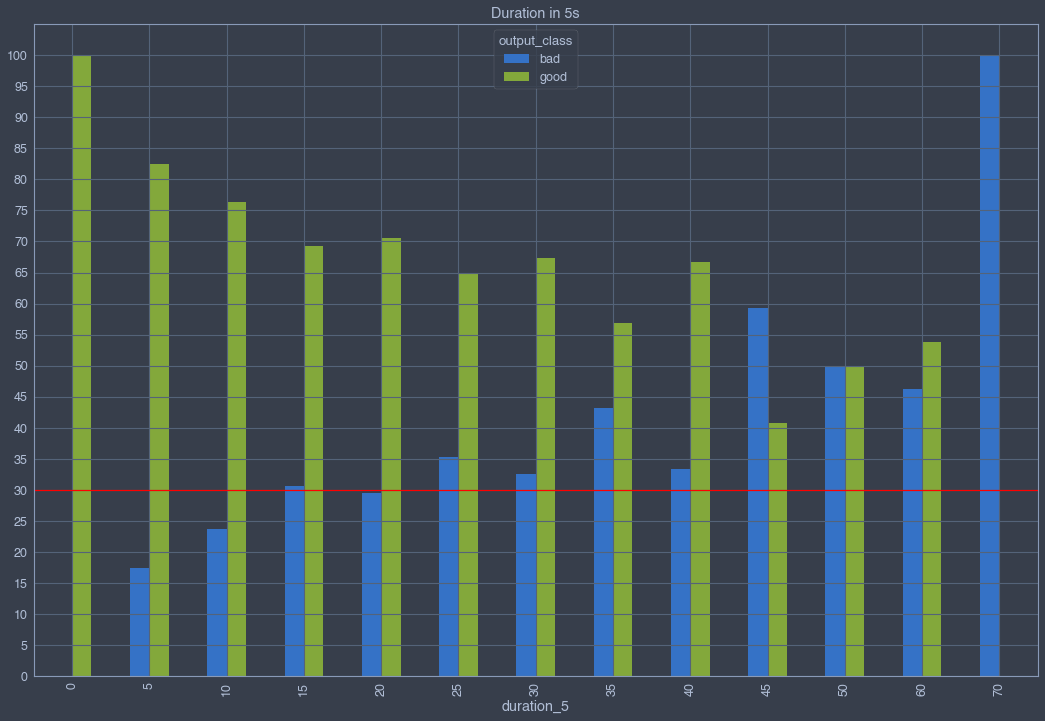

In [13]:
# Convert duration to groups of 5 months so that:
#  - an duration between 0 and 4 (incl.) has a value of 0
#  - an duration between 5 and 9 (incl.) has a value of 5
#  - an duration between 10 and 14 (incl.) has a value of 10
#  ... etc
df["duration_5"] = 5*(df.duration//5)
pivot_with_output_class(df, "duration_5", add_class_name=False)\
    .plot(kind="bar", figsize=(18, 12), title="Duration in 5s")
plt.yticks(range(0, 101, 5))
plt.axhline(y=30, color="red")
plt.show()

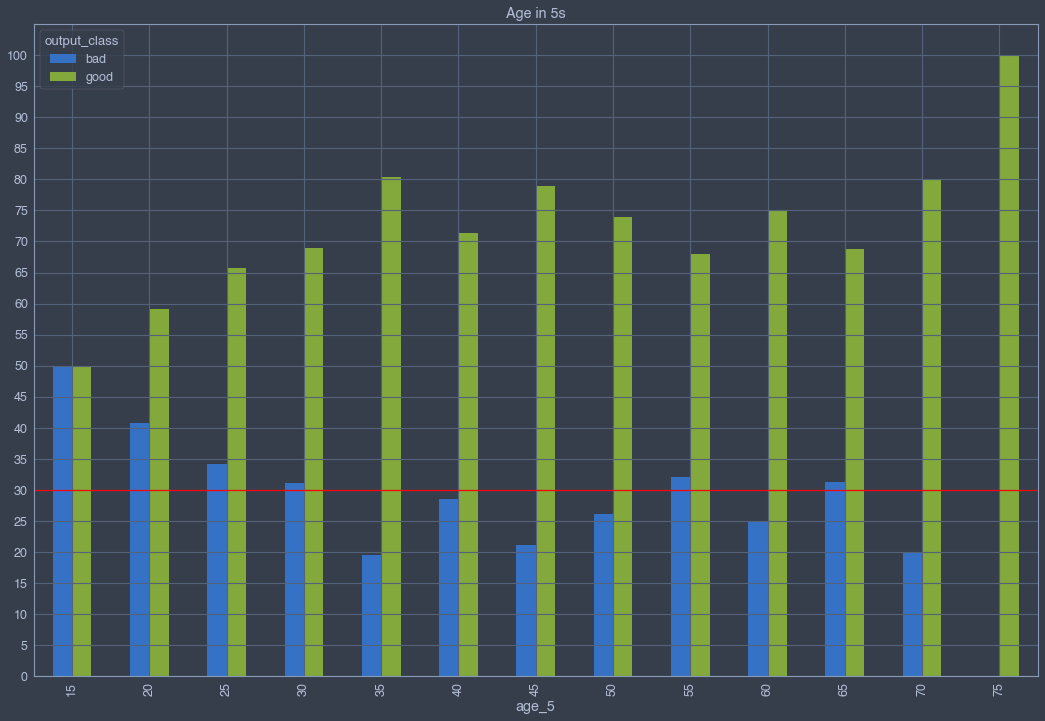

In [14]:
# Convert age to groups of 5 years so that:
#  - an age between 15 and 19 (incl.) has a value of 15
#  - an age between 20 and 24 (incl.) has a value of 20
#  - an age between 25 and 29 (incl.) has a value of 25
#  ... etc
df["age_5"] = 5*(df.age//5)
pivot_with_output_class(df, "age_5", add_class_name=False)\
    .plot(kind="bar", figsize=(18, 12), title="Age in 5s")
plt.yticks(range(0, 101, 5))
plt.axhline(y=30, color="red")
plt.show()

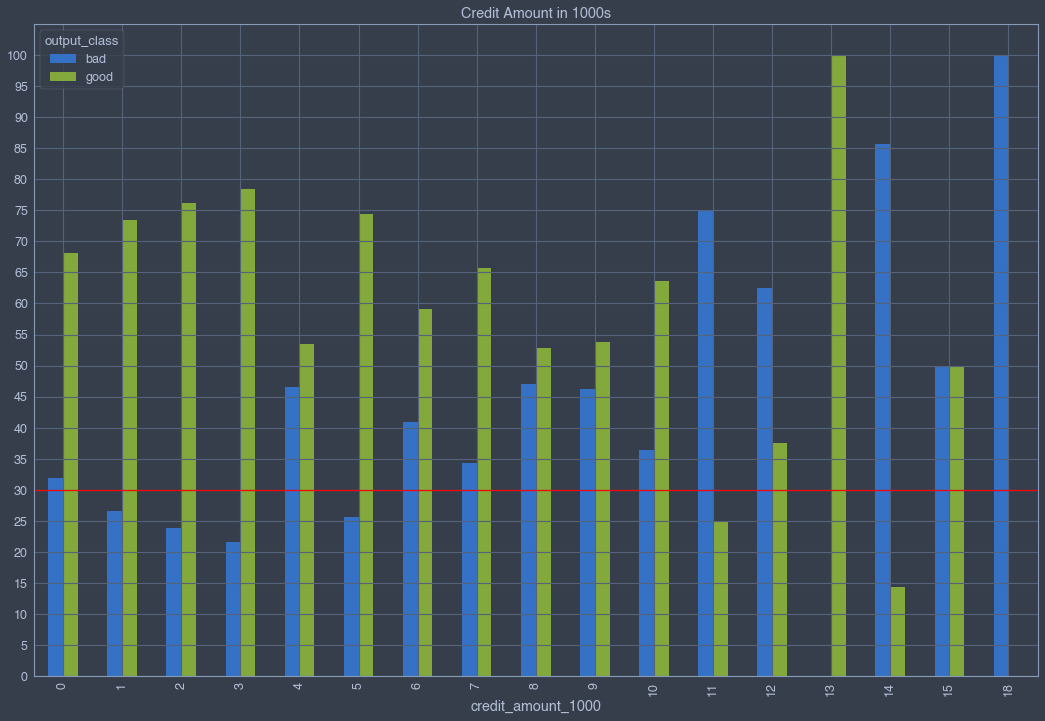

In [15]:
# Convert credit_amount to 1000s unit so that:
#  - anything below 1000 has a value of 0
#  - anything between 1000 and 1999 (inclusive) has a value of 1
#  - anything between 2000 and 2999 (inclusive) has a value of 1
#  ... etc
df["credit_amount_1000"] = df.credit_amount//1000
pivot_with_output_class(df, "credit_amount_1000", add_class_name=False)\
    .plot(kind="bar", figsize=(18, 12), title="Credit Amount in 1000s")
plt.yticks(range(0, 101, 5))
plt.axhline(y=30, color="red")
plt.show()

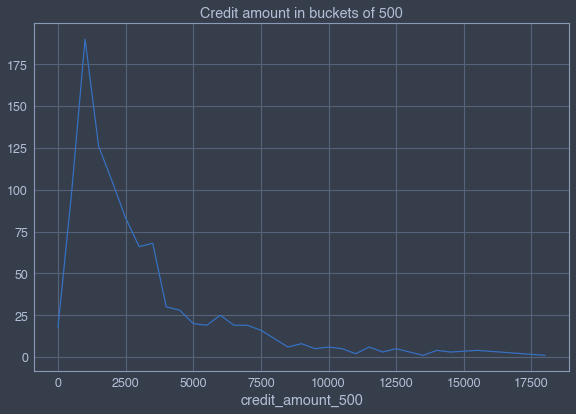

In [294]:
# Distribution of the credit amount
df.groupby("credit_amount_500").size().plot(title="Credit amount in buckets of 500")
plt.show()

### Takeaways
  - The shorter the duration, the less frequent the `bad` output
  - Credits with an amount larger than 4000 have a higher proportion of `bad` credit risk.
  - The risk becomes really big for loans above 11k
  - The longer the installment commitment, the more the risk of `bad` credit risk
  - The `num_dependents` feature doesn't seem to bring any extra information 
  - The `residence since` feature oesn't seem to bring any extra information 

# Modelling the credit risk
This is a classifiation problem so I will be using a RandomForestClassifier for the task. Other methods are possible but Random Forests scale well and work usually pretty okay.

## Some useful functions

In [16]:
def evaluate_kpis(ytrain: np.array, ytrainpred: np.array, 
                  ytest: np.array, ytestpred: np.array, 
                  return_kpis: bool = False, 
                  print_kpis: bool = True) -> Union[dict, None]:
    """
    Helper function to evaluate the accuracy & MCC scores for both the training & testing sets.
    :param ytrain: pd.Series or np.array containing the TRUE output classes for the training data.
    :param ytrainpred: pd.Series or np.array containing the PREDICTED output classes for the training data.
    :param ytest: pd.Series or np.array containing the TRUE output classes for the test data.
    :param ytestpred: pd.Series or np.array containing the PREDICTED output classes for the test data.
    :param return_kpis: Boolean to indicate whether the KPIs values should be returned by the function.
    :param print_kpis: Boolean to indicate whether to print the KPIs to the console.
    :return if `return_kpis` is False, the function returns None otherwise it returns a dict with the 
    values for the various KPIs.
    """
    acc_score_train = round(accuracy_score(ytrain, ytrainpred), 2)
    acc_score_test = round(accuracy_score(ytest, ytestpred), 2)
    
    mcc_score_train = round(matthews_corrcoef(ytrain, ytrainpred ), 2)
    mcc_score_test = round(matthews_corrcoef(ytest, ytestpred ), 2)
    
    if print_kpis:
        print("Accuracy (1 is best, 0 is worst)")
        print(f"\tTrain set: {acc_score_train}.")
        print(f"\tTest set: {acc_score_test}.")
        print(f"MCC score (1 is best, 0 is as good as random, -1 is inverse pred)")
        print(f"\tTrain set: {mcc_score_train}.")
        print(f"\tTest set: {mcc_score_test}")

    if return_kpis:
        return {"acc_train": acc_score_train,
                "acc_test": acc_score_test, 
                "mcc_train": mcc_score_train, 
                "mcc_test": mcc_score_test}

In [17]:
def get_random_forest_results(xtrain: np.array, ytrain: np.array,
                              xtest: np.array, class_weight: str = "balanced",
                              n_estimators: int = 200) -> tuple:
    """
    Helper function to trains a RandomForestClassifier and return the predicted values for both
    the training and test sets.
    :param xtrain: the training dataset with all training features selected.
    :param ytrain: the output classes for the training dataset.
    :param xtest: the test dataset to run the prediction on
    :param class_weight: String parameter passed directly to the instanciation of RandomForestClassifier
    :param n_estimators: Integer parameter passed directly to the instanciation of RandomForestClassifier
    :return a tuple with the (predictions training set, predictions test set, the trained model)
    """
    # Use balanced class_weight because of the imbalance in the output class
    rfc = RandomForestClassifier(class_weight=class_weight, n_estimators=n_estimators)
    rfc.fit(xtrain, ytrain)
    y_train_pred = rfc.predict(xtrain)
    y_predicted = rfc.predict(xtest)
    return y_train_pred, y_predicted, rfc

In [18]:
def get_datasets(indf: pd.DataFrame, target_vals: pd.Series,
                 columns_to_scale: list = []) -> tuple :
    """
    Helper function to split & return the data into a train & a test dataset
    :param indf: Input dataframe to use for the training & testing
    :param target_vals: The output class that we want to predict. It must have 
    as many values as the input dataframe
    :param columns_to_scale: A list of column names. When not empty, the StandardScaler
    is applied to them so each column has its values scaled between -1 and +1.
    :return The tuple (train data, test data, output for train data, output for test data)
    """
    # Use stratification as we have an imbalance in the output class
    X_train, X_test, y_train, y_test = train_test_split(indf.copy(), 
                                                        target_vals, 
                                                        stratify=target_vals,
                                                        test_size=0.23)
    if len(columns_to_scale) > 0:
        standard_scaler = StandardScaler()
        X_train[columns_to_scale] = standard_scaler.fit_transform(X_train[columns_to_scale])
        X_test[columns_to_scale] = standard_scaler.transform(X_test[columns_to_scale])
    return X_train, X_test, y_train, y_test

## Baseline
I will use *all* columns except `num_dependents` just to get a baseline. 

**Results**

Results are definitely not good as the accuracy on the train set is 1 (_i.e._ perfect) while the accuracy on the test is 0.77 (not as good).

Besides, the MCC score for the test set is at 0.4 (1 for the train set). 

The above results indicate that the model is overfitting the train set

In [148]:
numerical_columns_model = ['duration', 'credit_amount', 'installment_commitment',
                           'age', 'existing_credits']
cat_columns_model = ['checking_status', 'credit_history', 'purpose', 'savings_status', 
                     'employment', 'personal_status', 'other_parties', 'property_magnitude',  
                     'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']

df_model = pd.get_dummies(df[numerical_columns_model+cat_columns_model], 
                          columns=cat_columns_model, 
                          prefix_sep="|")
df_model['is_bad'] = np.where(df.output_class == "bad", 1, 0)

In [149]:
X_train, X_test, y_train, y_test = get_datasets(df_model.drop(columns="is_bad"),
                                                df_model["is_bad"].values,
                                                columns_to_scale=numerical_columns_model)

In [150]:
y_train_pred, y_predicted, rfc_baseline = get_random_forest_results(X_train.values, y_train, X_test)
evaluate_kpis(y_train, y_train_pred, y_test, y_predicted)

Accuracy (1 is best, 0 is worst)
	Train set: 1.0.
	Test set: 0.77.
MCC score (1 is best, 0 is as good as random, -1 is inverse pred)
	Train set: 1.0.
	Test set: 0.4


In [151]:
feature_importance = pd.DataFrame(zip(df_model.drop(columns="is_bad").columns, rfc_baseline.feature_importances_), columns=["feature", "importance"])
feature_importance.sort_values("importance", ascending=False, inplace=True)
print("Top 10")
display(feature_importance.head(10))

print("Bottom 10")
display(feature_importance.tail(10))

Top 10


,feature,importance
1,credit_amount,0.102683
3,age,0.083481
0,duration,0.079754
8,checking_status|no checking,0.073388
2,installment_commitment,0.034024
6,checking_status|<0,0.030220
10,credit_history|critical/other existing credit,0.024172
26,savings_status|<100,0.020897
5,checking_status|0<=X<200,0.019066
18,purpose|new car,0.019001


Bottom 10


,feature,importance
38,other_parties|co applicant,0.006072
35,personal_status|male div/sep,0.005829
47,other_payment_plans|stores,0.005828
21,purpose|repairs,0.004326
58,foreign_worker|yes,0.004141
57,foreign_worker|no,0.003839
53,job|unemp/unskilled non res,0.001634
19,purpose|other,0.001610
15,purpose|domestic appliance,0.001385
22,purpose|retraining,0.001083


## Feature pruning
In this section, I use the feature importance computed above to see if I can get a good model by limiting the features to the top N

**Results**

Results look terrible from the 1st feature used: it overfits the training data and performs poorly on the test data.

In [29]:
feature_importance['feature_name'] = feature_importance.feature.apply(lambda x: x.split("|")[0])
feature_importance.head()

,feature,importance,feature_name
1,credit_amount,0.099211,credit_amount
3,age,0.082292,age
0,duration,0.077590,duration
8,checking_status|no checking,0.064894,checking_status
6,checking_status|<0,0.037265,checking_status


In [30]:
numerical_columns_for_pred = []
categorical_columns_for_pred = []
kpi = []

for column in feature_importance.feature_name.unique():
    # Prepare dataset
    if is_string_dtype(df[column]):
        categorical_columns_for_pred.append(column)
    else:
        numerical_columns_for_pred.append(column)
    df_model = df[numerical_columns_for_pred + categorical_columns_for_pred].copy()
    # One-hot encode categoricals, if any
    if len(categorical_columns_for_pred) > 0:
        df_model = pd.get_dummies(df_model, columns=categorical_columns_for_pred)
    # Add output class
    df_model['is_bad'] = np.where(df.output_class == 'bad', 1, 0)

    # get datasets for training & evaluation
    X_train, X_test, y_train, y_test = get_datasets(df_model.drop(columns="is_bad"), 
                                                    df_model["is_bad"].values,
                                                    columns_to_scale=numerical_columns_for_pred)

    # train, evaluate & store
    y_train_pred, y_predicted, _ = get_random_forest_results(X_train, y_train, X_test)
    res = evaluate_kpis(y_train, y_train_pred, y_test, y_predicted, return_kpis=True, print_kpis=False )    
    res['column'] = column
    kpi.append(res)

kpi = pd.DataFrame(kpi)
kpi.head()

,acc_train,acc_test,mcc_train,mcc_test,column
0,0.98,0.62,0.95,0.07,credit_amount
1,1.00,0.64,1.00,0.11,age
2,1.00,0.69,1.00,0.16,duration
3,1.00,0.75,1.00,0.36,checking_status
4,1.00,0.72,1.00,0.28,installment_commitment


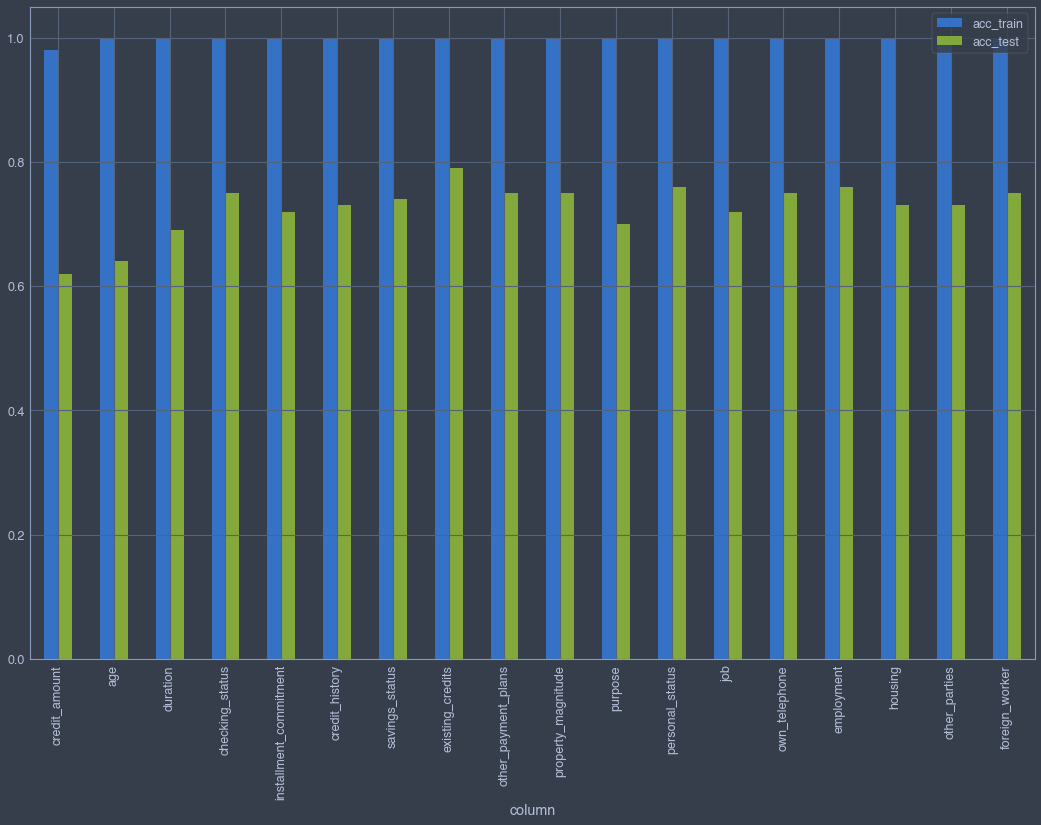

In [31]:
kpi.plot(x="column", y=["acc_train", "acc_test"], figsize=(18, 12))
plt.show()

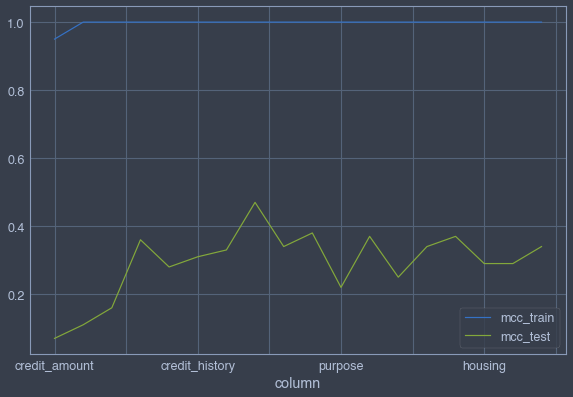

In [32]:
kpi.plot(x="column", y=["mcc_train", "mcc_test"])
plt.show()

# Which feature leads to overfitting?
In this section, I try to identify the feature(s) that make the model overfit. I do this by:
  - creating all possible combinations of the features of length N. For example, a combination of length 2 would be:
    
    (feature_1, feature_2), (feature_1, feature_3), ... ,(feature_N, feature_N-1)
  - Seeing which are the ones that contribute to the overfitting

**Results**

Results show that `credit_amount, age, duration` push the model to overfit the training data.

Also, after trying multiple lengths for the combination, I settled on a length of 4 where the performance of the model seems acceptable.

In [181]:
feature_list = ['checking_status', 'duration', 'credit_history', 'purpose',
                'credit_amount', 'savings_status', 'employment',  'installment_commitment',
                'personal_status', 'other_parties', 'residence_since', 'property_magnitude', 
                'age', 'other_payment_plans', 'housing', 'existing_credits', 'job', 
                'num_dependents', 'own_telephone', 'foreign_worker' ]
# Remove features that cause overfitting
feature_list.remove("credit_amount")
feature_list.remove("age")
feature_list.remove("duration")

In [ ]:
kpi = []
for two_cols in tqdm(combinations(feature_list, 4)):
    if two_cols[0] == two_cols[1]:
        continue
    # Prepare dataset
    # identifying categorical vs numerical columns helps in deciding how to treat them
    categorical_columns_for_pred = [_ for _ in two_cols if is_string_dtype(df[_])]
    numerical_columns_for_pred = [_ for _ in two_cols if not is_string_dtype(df[_])]
    df_model = df[numerical_columns_for_pred + categorical_columns_for_pred].copy()
    
    # One-hot encode categoricals, if any
    if len(categorical_columns_for_pred) > 0:
        df_model = pd.get_dummies(df_model, columns=categorical_columns_for_pred)
    # Add output class
    df_model['is_bad'] = np.where(df.output_class == 'bad', 1, 0)

    # get datasets for training & evaluation
    X_train, X_test, y_train, y_test = get_datasets(df_model.drop(columns="is_bad"), 
                                                    df_model["is_bad"].values,
                                                    columns_to_scale=numerical_columns_for_pred)

    # train, evaluate & store
    y_train_pred, y_predicted, _ = get_random_forest_results(X_train, y_train, X_test)
    res = evaluate_kpis(y_train, y_train_pred, y_test, y_predicted, return_kpis=True, print_kpis=False )    
    res['column'] = "-".join(two_cols)
    kpi.append(res)

kpi = pd.DataFrame(kpi)

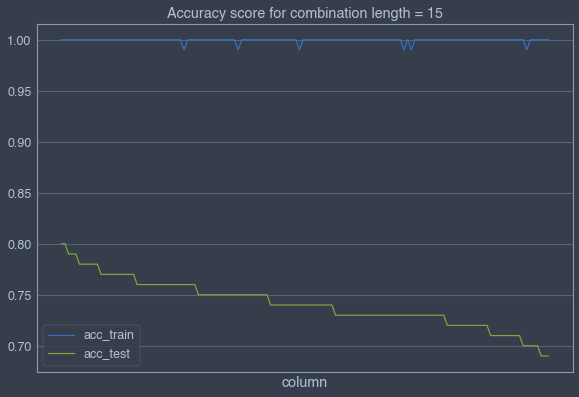

In [299]:
kpi\
    .sort_values("acc_test", ascending=False)\
    .plot(x="column", y=["acc_train", "acc_test"],
         title="Accuracy score for combination length = 15")
# X-axis would be unreadable here, so better remove it
plt.xticks([], [])
plt.show()

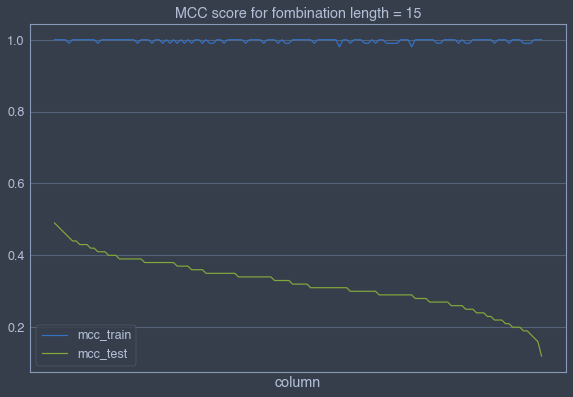

In [300]:
kpi\
    .sort_values("mcc_test", ascending=False)\
    .plot(x="column", y=["mcc_train", "mcc_test"],
         title="MCC score for fombination length = 15")
# X-axis would be unreadable here, so better remove it
plt.xticks([], [])
plt.show()

# Final model

In [274]:
numerical_columns_model = []
cat_columns_model = ['checking_status', 'other_parties', 'property_magnitude',  'foreign_worker']
df_model = pd.get_dummies(df[numerical_columns_model+cat_columns_model], 
                          columns=cat_columns_model, 
                          prefix_sep="|")
df_model['is_bad'] = np.where(df.output_class == "bad", 1, 0)

X_train, X_test, y_train, y_test = get_datasets(df_model.drop(columns="is_bad"),
                                                df_model["is_bad"].values,
                                                columns_to_scale=numerical_columns_model)

y_train_pred, y_predicted, rfc_baseline = get_random_forest_results(X_train.values, y_train, X_test)
evaluate_kpis(y_train, y_train_pred, y_test, y_predicted)

Accuracy (1 is best, 0 is worst)
	Train set: 0.7.
	Test set: 0.7.
MCC score (1 is best, 0 is as good as random, -1 is inverse pred)
	Train set: 0.41.
	Test set: 0.38
